In [1]:
import config as cfg

import numpy as np
import pandas as pd
import scanpy as sc

# import PCA
from sklearn.decomposition import PCA

import torch
from torch import tensor as tt

import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import module as md

torch_models successfully imported.


### Importing data and dimensionality reduction

In [3]:
help(md.get_data_from_anndata)

Help on function get_data_from_anndata in module module.utils:

get_data_from_anndata(path, gene_list=None, cell_list=None)
    This function loads data from an AnnData object, performs filtering and normalization, and returns several outputs.
    the function also removes the bad replicate, removes mitochondrial genes, and filters cells with an unusual number of reads + too low mito content.
    
    Parameters:
    path (str): The path to the AnnData object file.
    gene_list (list, optional): A list of gene names to be retrieved. If None, all genes are retrieved.
    cell_list (list, optional): A list of cell names to be retrieved. If None, all cells are retrieved.
    
    Returns:
    tuple: A tuple containing six elements:
        - data (anndata.AnnData): The filtered and normalized AnnData object.
        - data_zonated (anndata.AnnData): The AnnData object filtered to include only the genes specified in gene_list.
        - n_c (numpy.ndarray): The sum of counts per cell.
   

In [4]:
# path = "/Users/salati/Documents/CODE/github/scCircadianMeta/data/LIVER/concatenated.h5ad"
path="/home/maxine/Documents/andrea/scCircadianMeta/data/LIVER/concatenated.h5ad"
adata = sc.read_h5ad(path)

NC, NG = adata.shape

In [5]:
sample_names = adata.obs["sample_name"].values
sample_names_u = np.unique(sample_names)

In [6]:
adata.obs["s_counts"].mean()

1972.2065182142471

In [7]:
sample_id = np.zeros(NC, dtype=np.int64)
for i, s in enumerate(sample_names_u):
    sample_id[sample_names == s] = i

np.unique(sample_id)
dm = md.make_design_matrix(torch.tensor(sample_id, dtype=float)) # change
dm.shape
# dm = make_design_matrix_numpy(sample_id)


torch.Size([18502, 10])

In [9]:
data = adata[:, cfg.genes]
data.obs["n_c"] = adata.obs["s_counts"].copy()
data.layers["f_cg"] = data.layers["s_norm"].toarray()

/tmp/ipykernel_1699588/4128255765.py:2: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  data.obs["n_c"] = adata.obs["s_counts"].copy()


### PCA to initalize the lobular coordinate $x$

In [48]:
pca = PCA(n_components=2, whiten=False)
X_pca = data.layers["f_cg"].copy()

# normalize yourself
X_pca = X_pca - X_pca.mean(axis=0)[None, :]
X_pca = X_pca / np.sqrt(X_pca.var(axis=0))[None, :]
PC = pca.fit_transform(X_pca)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0, 0.5, 'PC2 entries values')

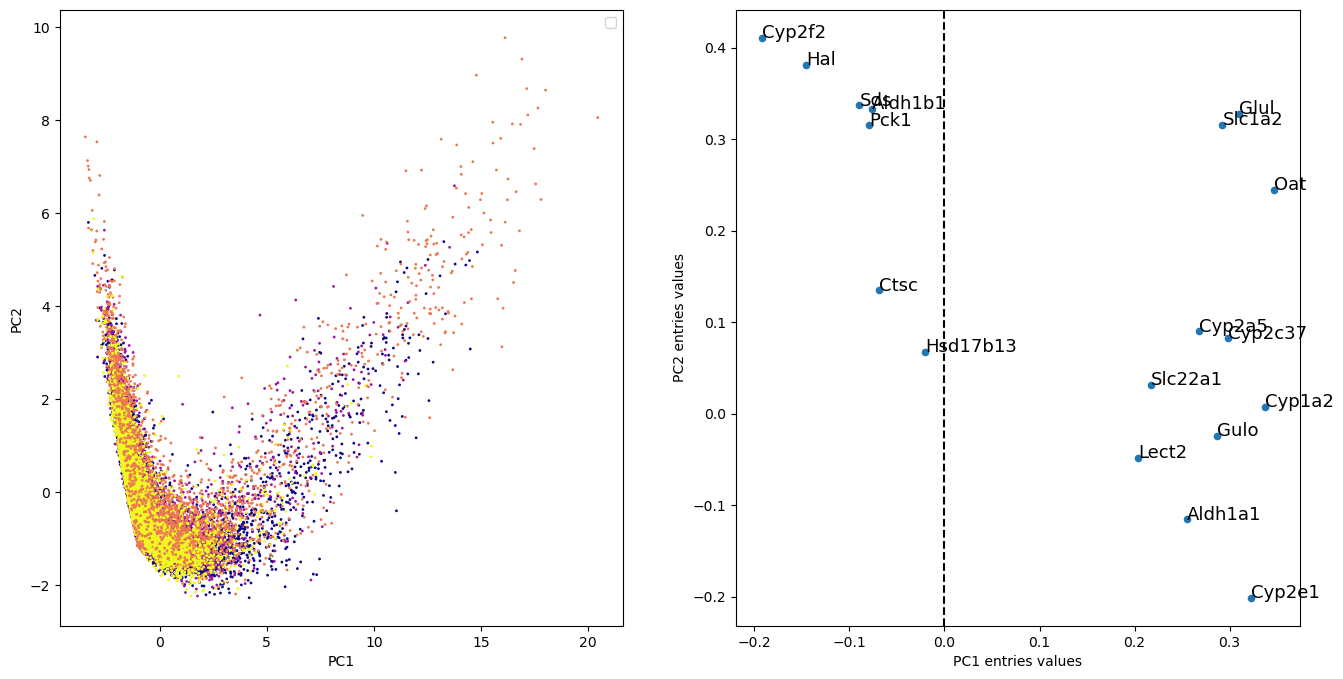

In [12]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.scatter(PC[:, 0], PC[:, 1],  s=1, c=adata.obs["ZTmod"].values, cmap='plasma')


plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
# plt.scatter(PC[:,0], PC[:,1], s=1,  c=mask_f, cmap='plasma')
# first two eigenvectors
x = pca.components_[0, :]
y = pca.components_[1, :]

plt.subplot(122)
plt.scatter(x, y, 20)
ix = np.abs(x) > np.percentile(np.abs(x), 0)
iy = np.abs(y) > np.percentile(np.abs(y), 0)
ii = np.logical_or(ix, iy)
# print(np.sum(ii))
for i, txt in enumerate(data.var.index[ii]):
    plt.annotate(txt, (x[ii][i], y[ii][i]), fontsize=13)

#plot a vertical line for x = 0
plt.axvline(x=0, color='k', linestyle='--')

plt.xlabel("PC1 entries values")
plt.ylabel("PC2 entries values")


We can observe that PC1 perfectly separates protal to central genes, we therefore leverage the projection of data on such first principal component to initialize the bayesian model latent variables

In [13]:
# component that captures zonation, it needs to be checked
pc = 0
x_unif = PC[:, pc]
x_unif = x_unif - x_unif.mean()
x_unif = x_unif / np.sqrt(x_unif.var())

Here we also fit the the gene coefficients $a_g$ and $b_g$ with a Generalized Linear Model with Negative Bionomial noise: 
$$\forall c \forall g \\
\mu_{c,g} = exp(a_g * x_c + b_g)
$$
where $\mu_{c,g}$ is the mean of the negative binomial distrbution that generates the data entry $E_{c,g}$  
In this step the positions are kept fixed and the coefficients $a$ and $b$ are found for every gene

In [14]:
coef_pau = md.fit_coeff(data, x_unif, cfg.genes, layer="spliced")

## Model's training with gradient descent

Here we start the training:

In [15]:
help(md.training)

Help on function training in module module.torch_models:

training(data, x_unif, coef_pau, n_c, dm, clamp, n_iter, batch_size, dev)
    Trains a model using PyTorch on the provided dataset.
    
    This function initializes and optimizes model parameters to fit the given data. It is the sole function where PyTorch is utilized for computational operations. The training involves gradient descent optimization using the Adam optimizer. The function also handles device setting for PyTorch operations.
    
    Parameters:
    data (array-like): The dataset used for training.
    x_unif (array-like): Vector to initialize values of latent variable x.
    coef_pau (array-like): Coefficients a1_g and a0_g of the model.
    n_c (array-like): The number of counts per cell.
    dm (array-like): The design matrix created from the sample identifiers.
    clamp (int): An index specifying which dimension to clamp during training. It gets rid of one of the likelihood symmetries.
    n_iter (int): Numbe

In [16]:
# converting to tensor
dm = tt(dm, dtype=torch.float32)
n_c = data.obs["n_c"].values

/tmp/ipykernel_1699588/1210736787.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  dm = tt(dm, dtype=torch.float32)


This cell is the traiing one, so it will take a while to execute

In [18]:
# the index of the gene to clamp
clamp = md.gene_index(data, cfg.clamp_gene)

x_, a0_, a1_, disp, losses = md.training(
    data=data.layers["spliced"].toarray(),
    x_unif=x_unif,
    coef_pau=coef_pau,
    n_c=n_c,
    dm=dm,
    clamp=clamp,
    n_iter=10000,
    batch_size=1,
    dev="cuda",
)

/home/maxine/miniconda3/envs/torch/lib/python3.8/site-packages/torch/utils/_device.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
Training progress: 100%|██████████| 10000/10000 [00:31<00:00, 316.48it/s]


Text(0.5, 1.0, 'Loss function')

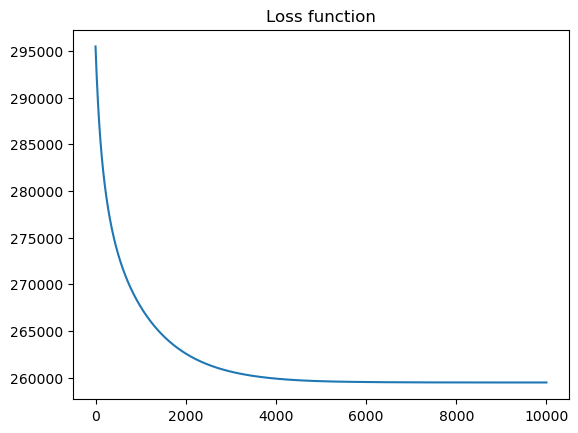

In [25]:
plt.plot(tt(losses).cpu().detach().numpy())
plt.title("Loss function")

Text(0, 0.5, 'GLM component')

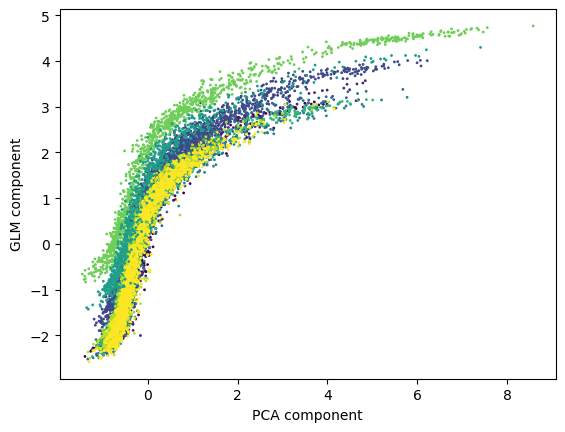

In [26]:
plt.scatter(x_unif, x_, s=1, c=sample_id)
plt.xlabel("PCA component")
plt.ylabel("GLM component")

This is the final output of the code, it's the x positions that are used in the GLMM

In [50]:
x_shifted, a0_shifted, a1_shifted, xs = md.shift_samples_per_mouse(
    x_, a0_, a1_, sample_id, cfg.central, data, layer="f_cg"
)

Text(0, 0.5, 'GLM component SHIFTED')

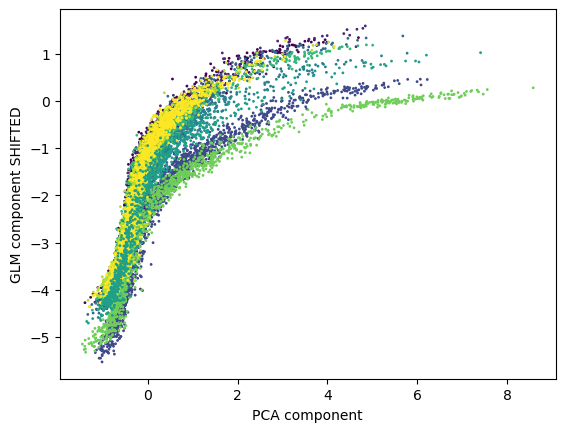

In [83]:
plt.scatter(x_unif, x_shifted, s=1, c=sample_id)
plt.xlabel("PCA component")
plt.ylabel("GLM component SHIFTED")

In [62]:
data.obs_names
df_x = pd.Series(x_, index=data.obs_names)
df_x.to_csv("droin_x.csv", sep=",")

adata.obs["x"] = x_

# plots


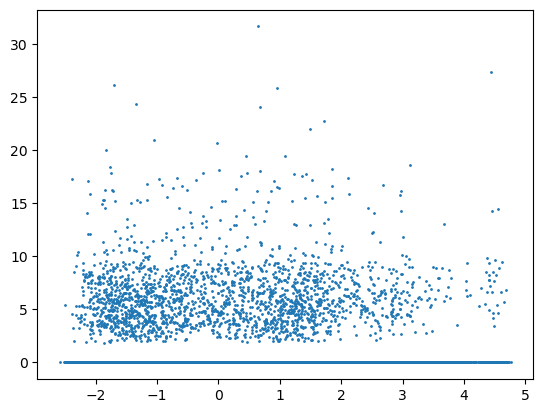

In [82]:
plt.scatter(adata.obs["x"], adata[:, "Dbp"].layers["s_norm"].toarray().squeeze(), s=1)

In [68]:
# do pca on adam_concat and show 2 pcs
sc.tl.pca(adata, svd_solver="arpack")
sc.pp.neighbors(adata, n_pcs=30)
sc.tl.umap(adata)

/home/maxine/miniconda3/envs/torch/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/maxine/miniconda3/envs/torch/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/maxine/miniconda3/envs/torch/lib/python3.8/site-packages/umap/dist

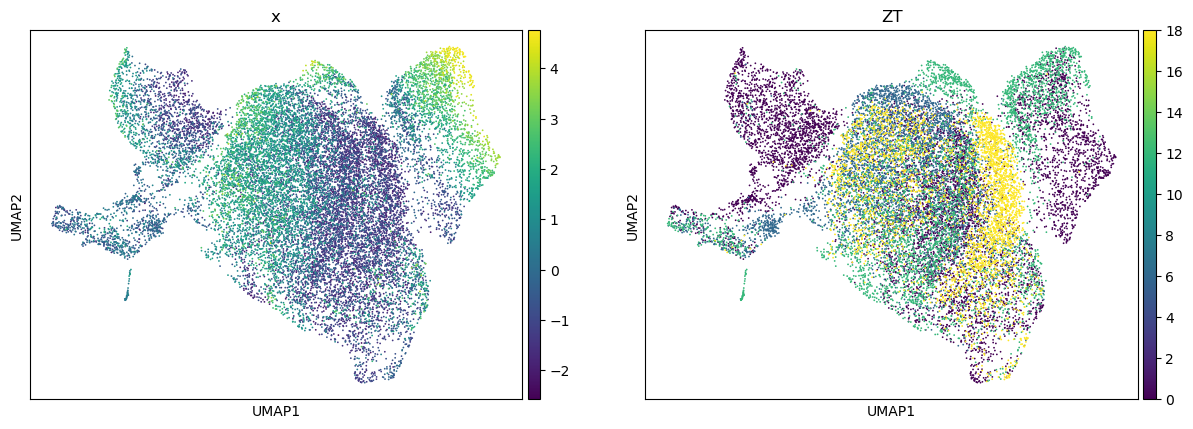

In [70]:
# plot adata colored by x
sc.pl.umap(adata, color=["x", "ZT"], cmap="viridis")

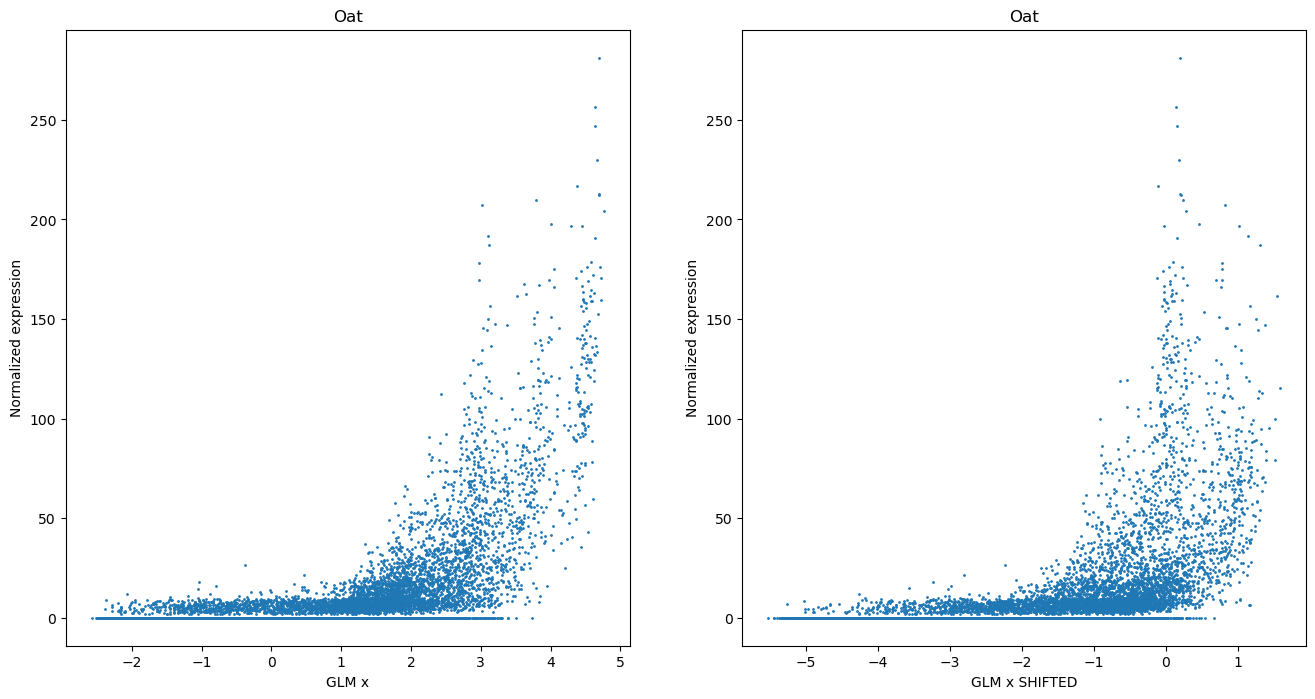

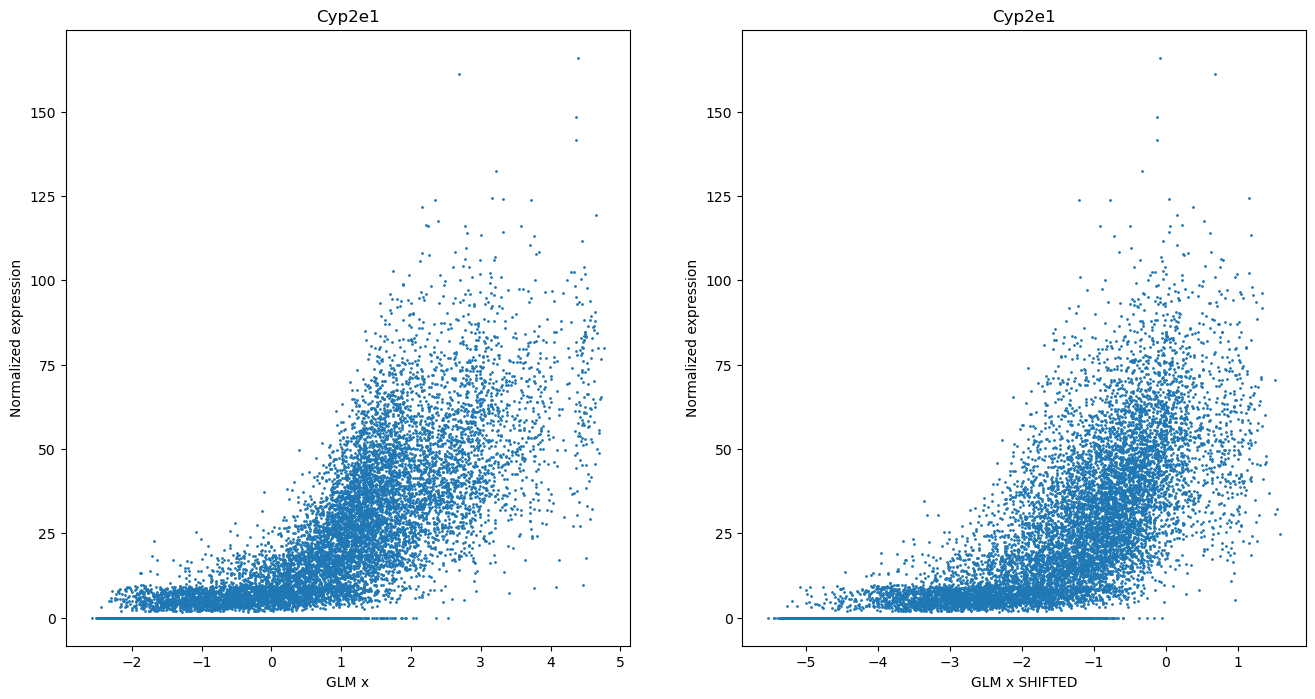

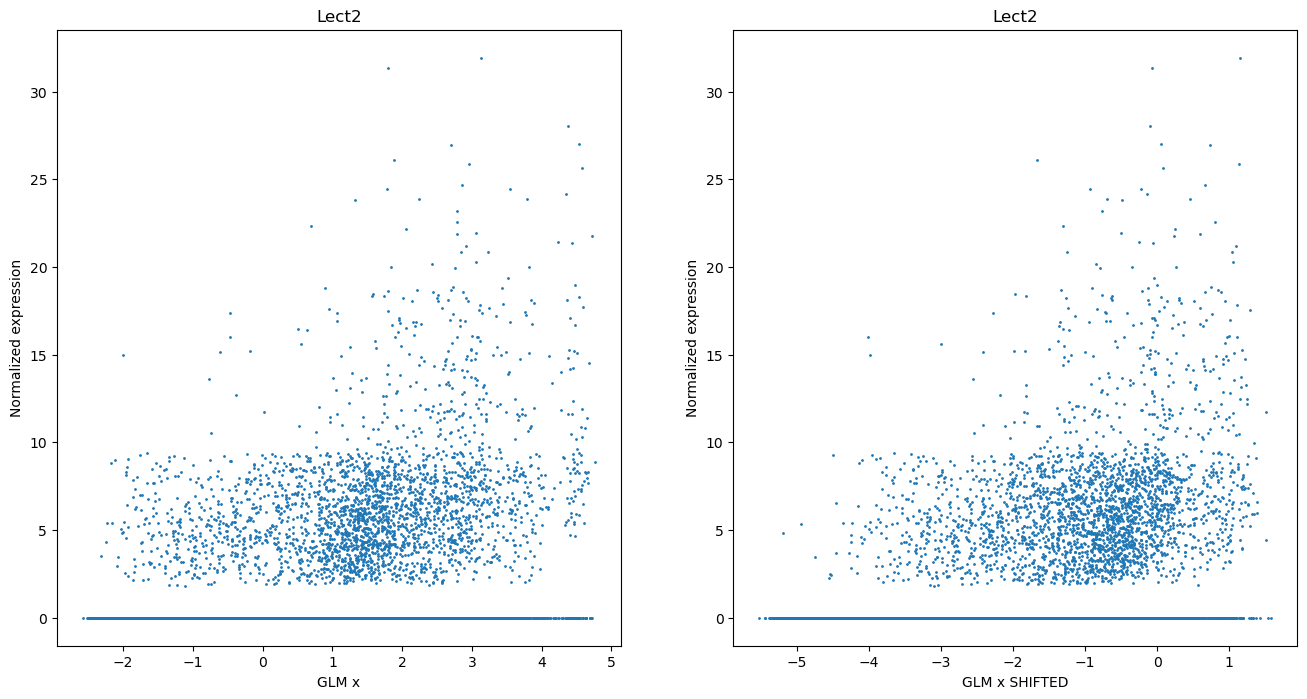

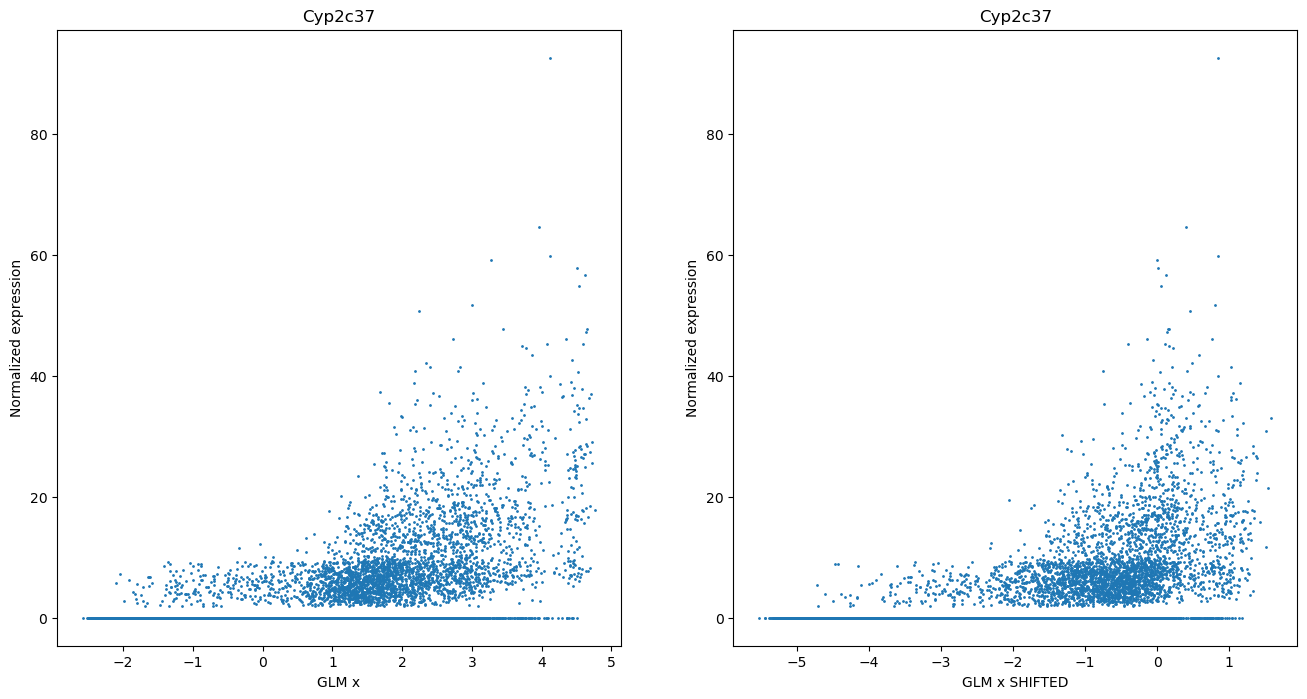

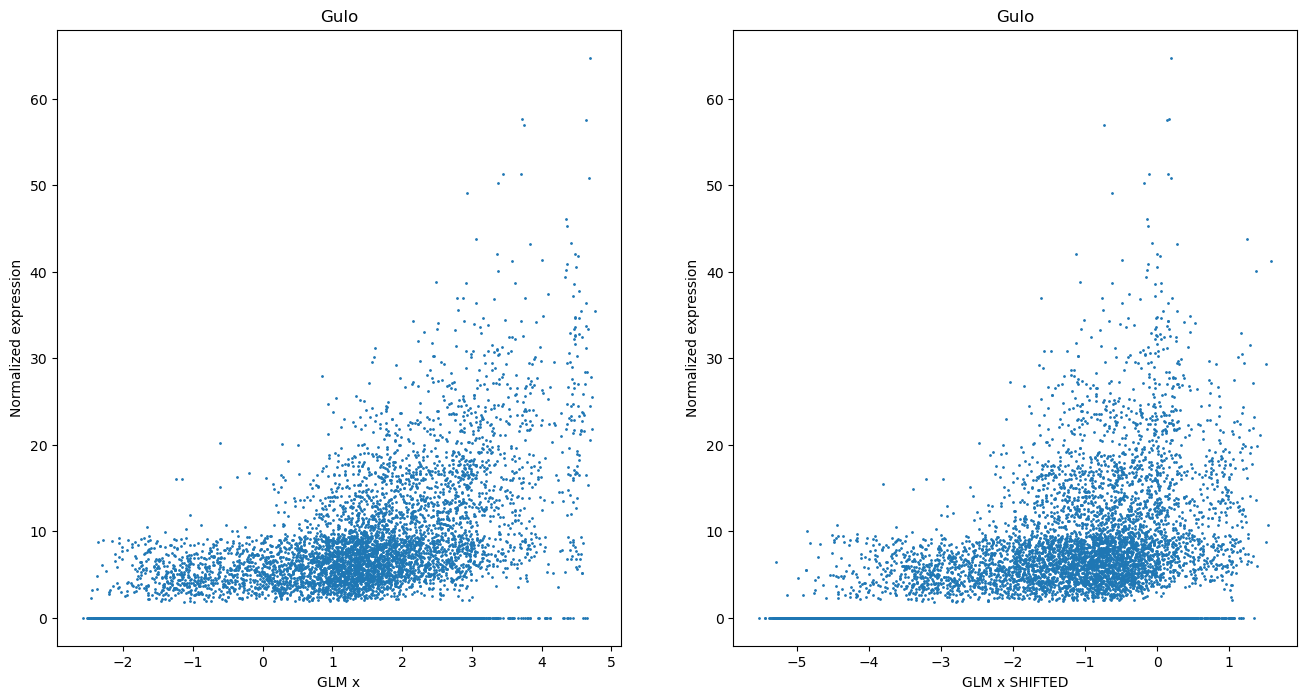

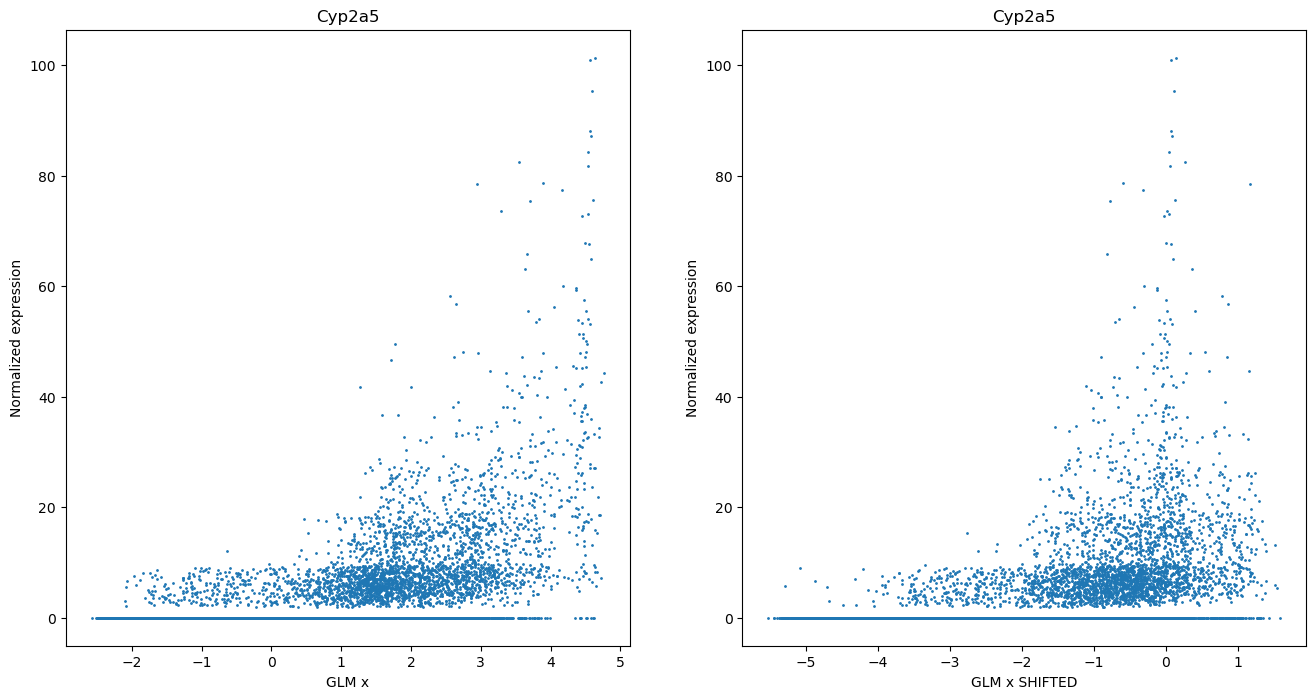

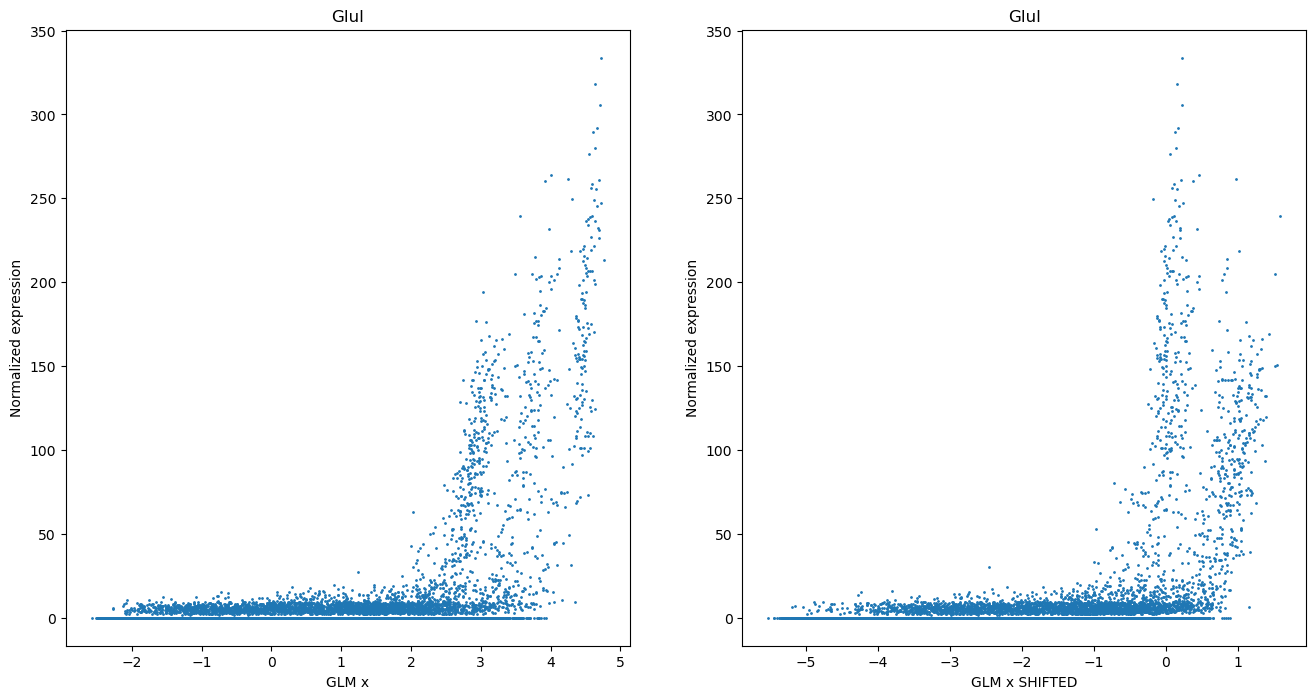

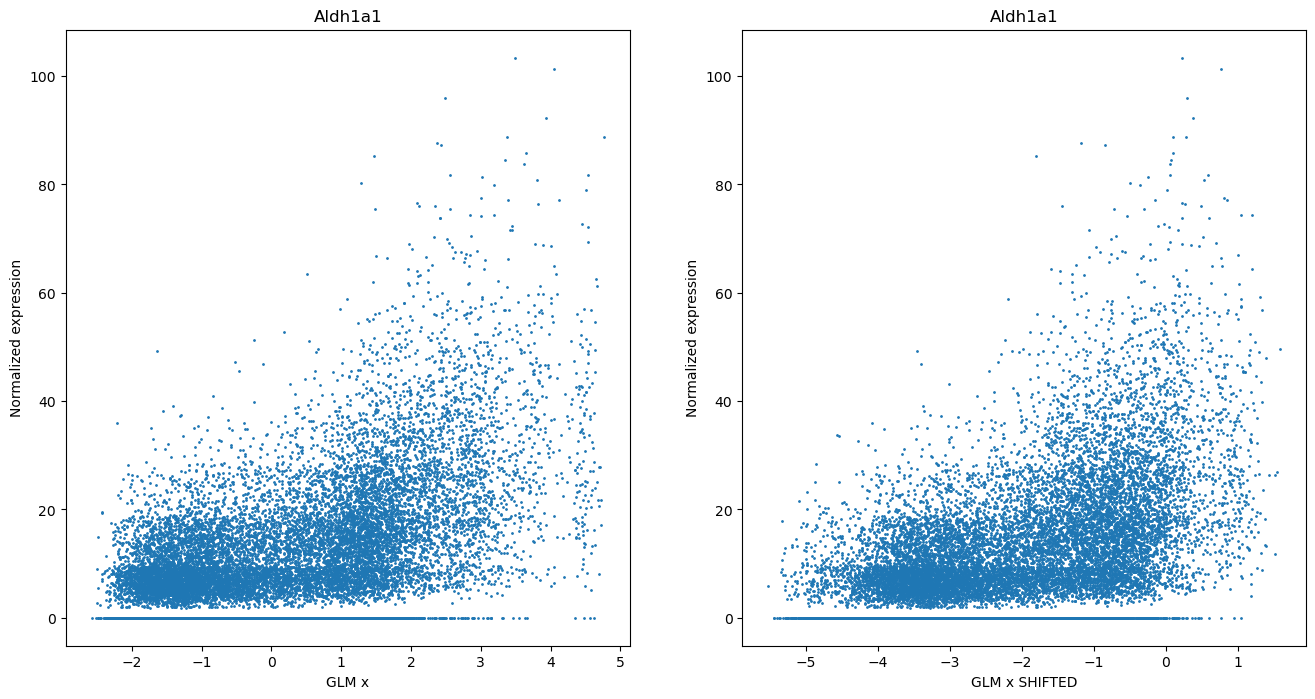

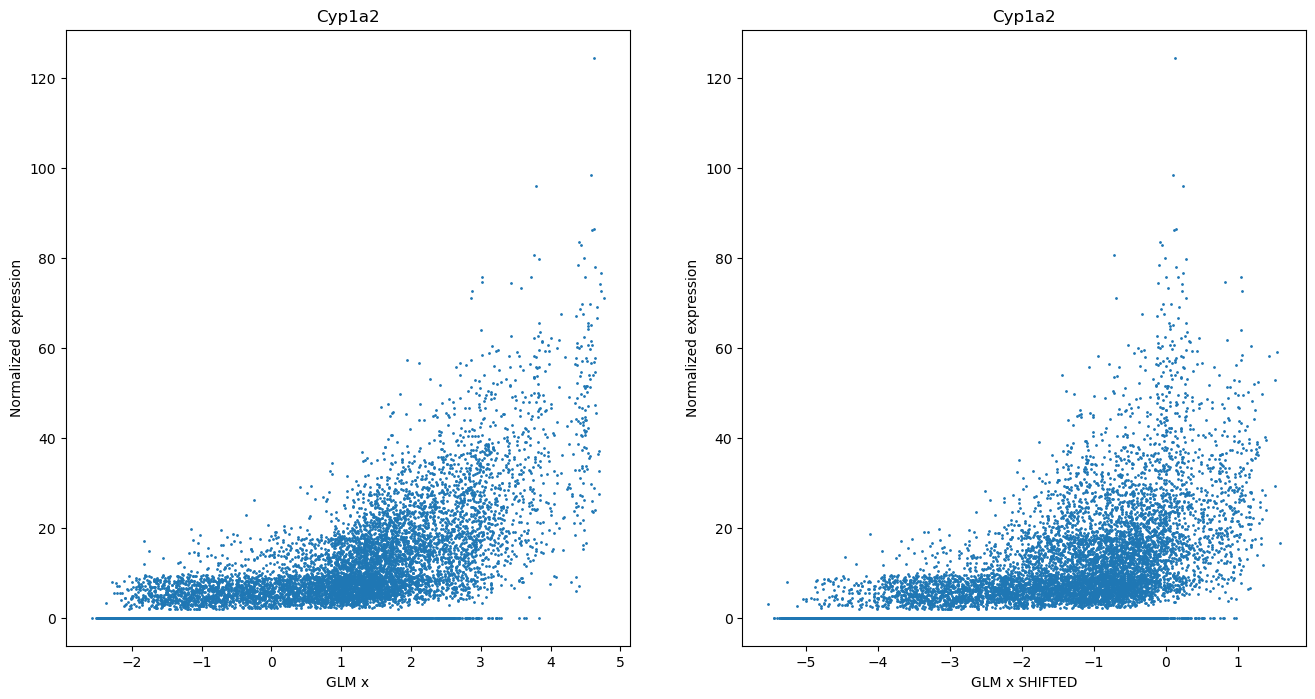

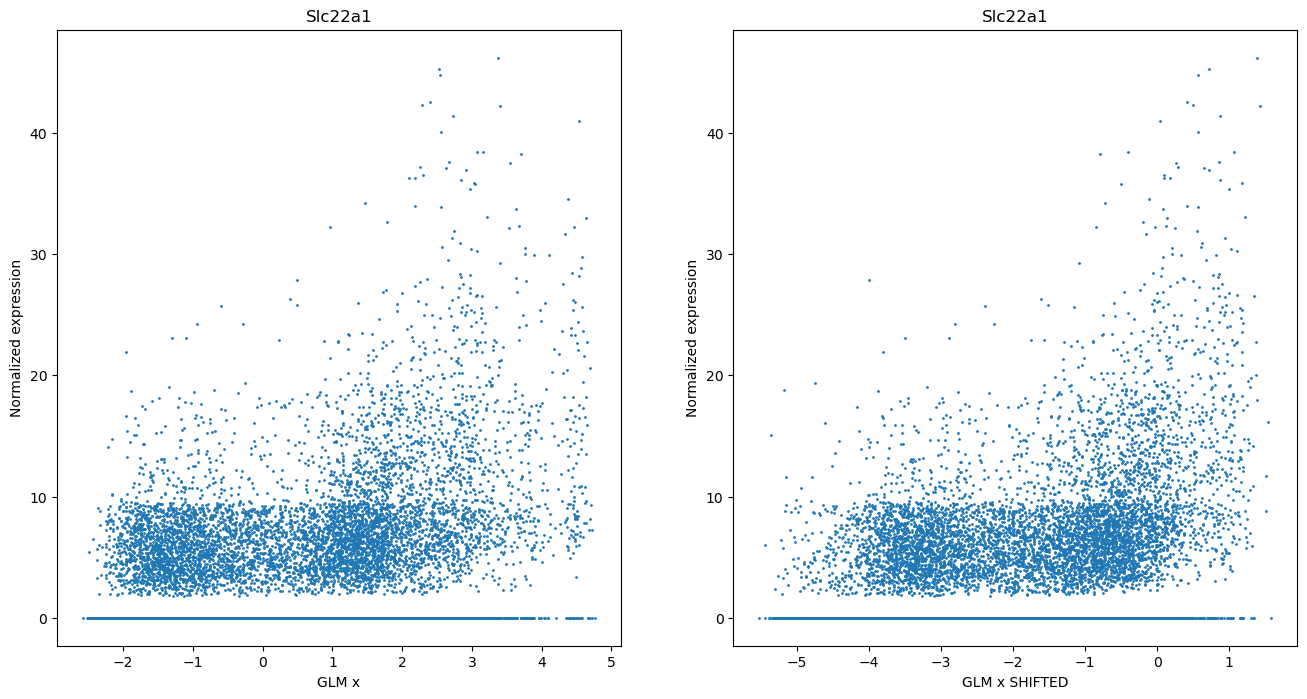

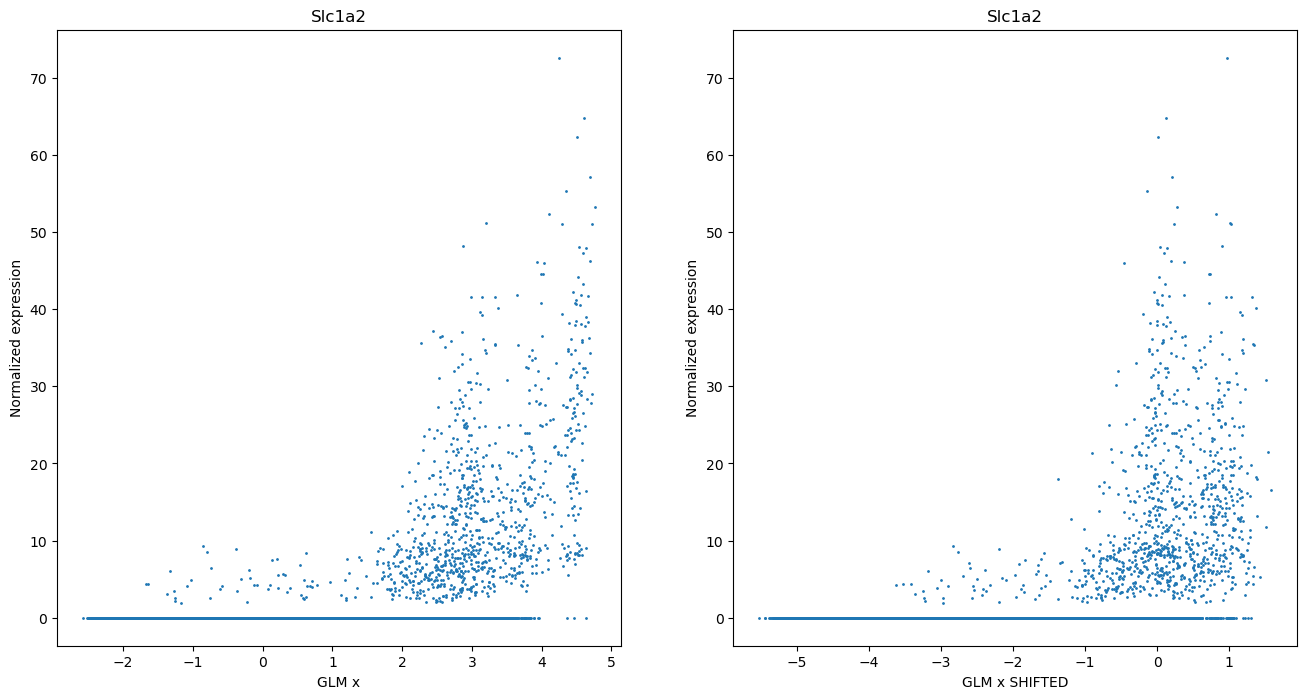

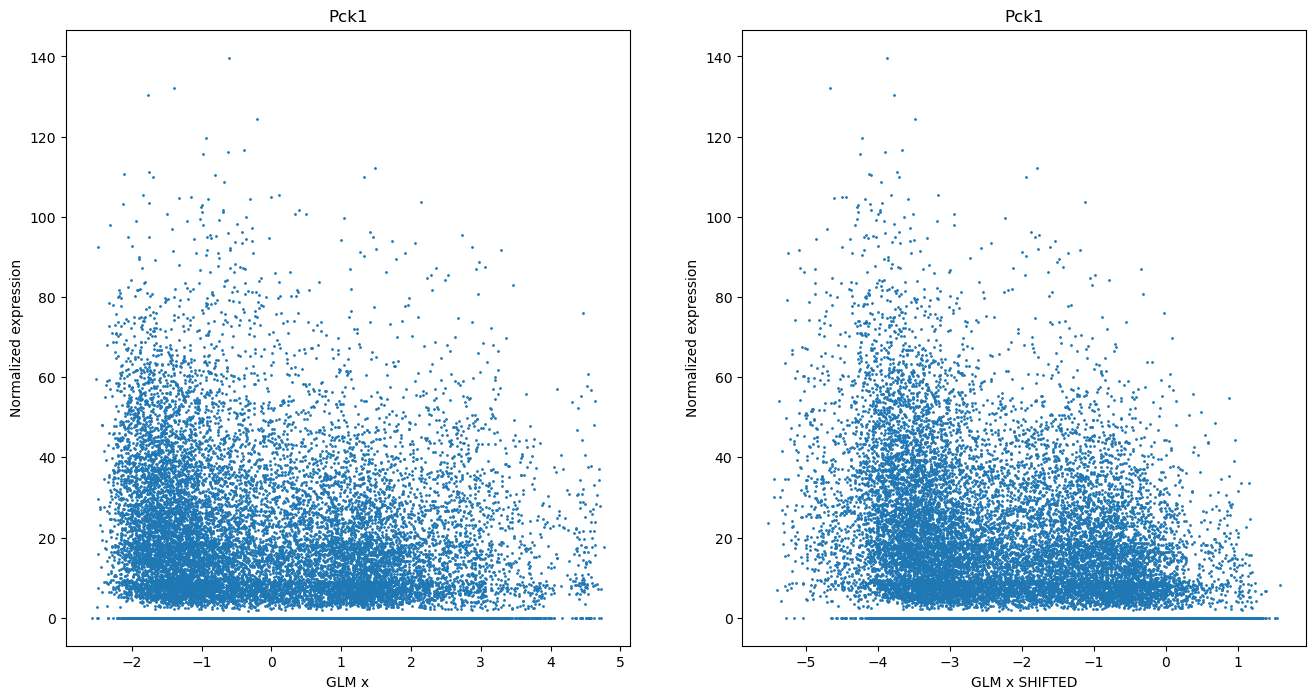

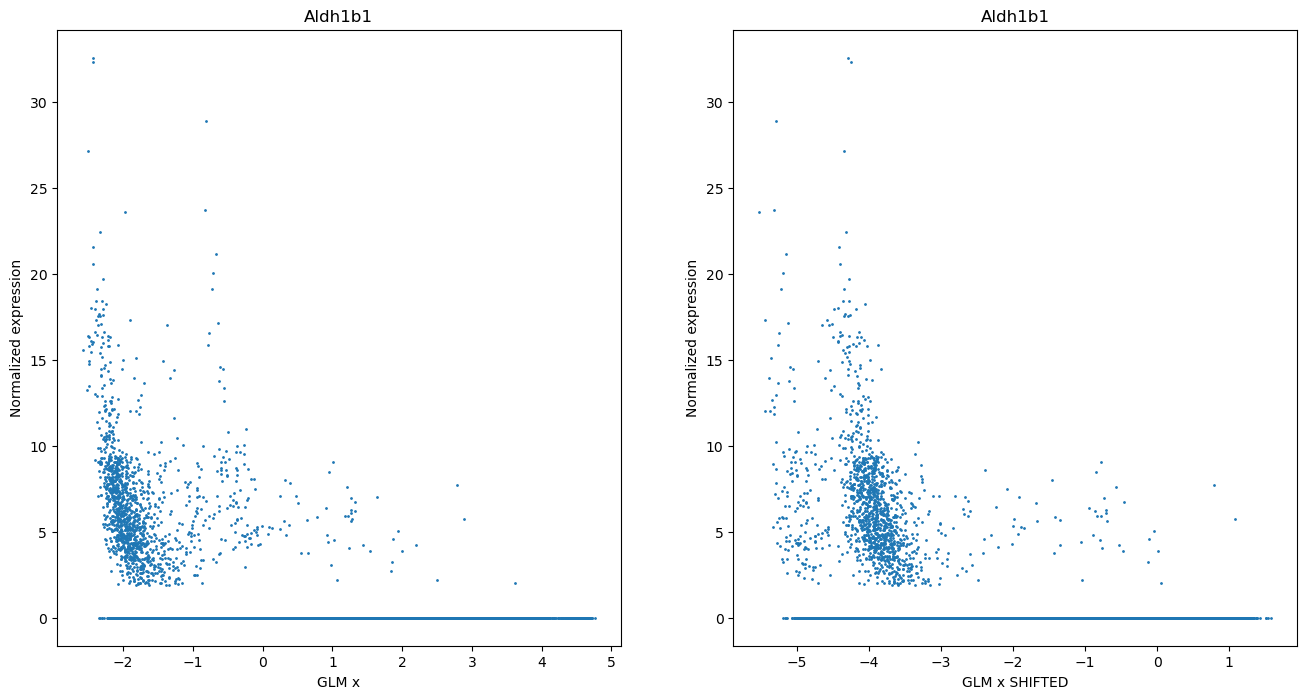

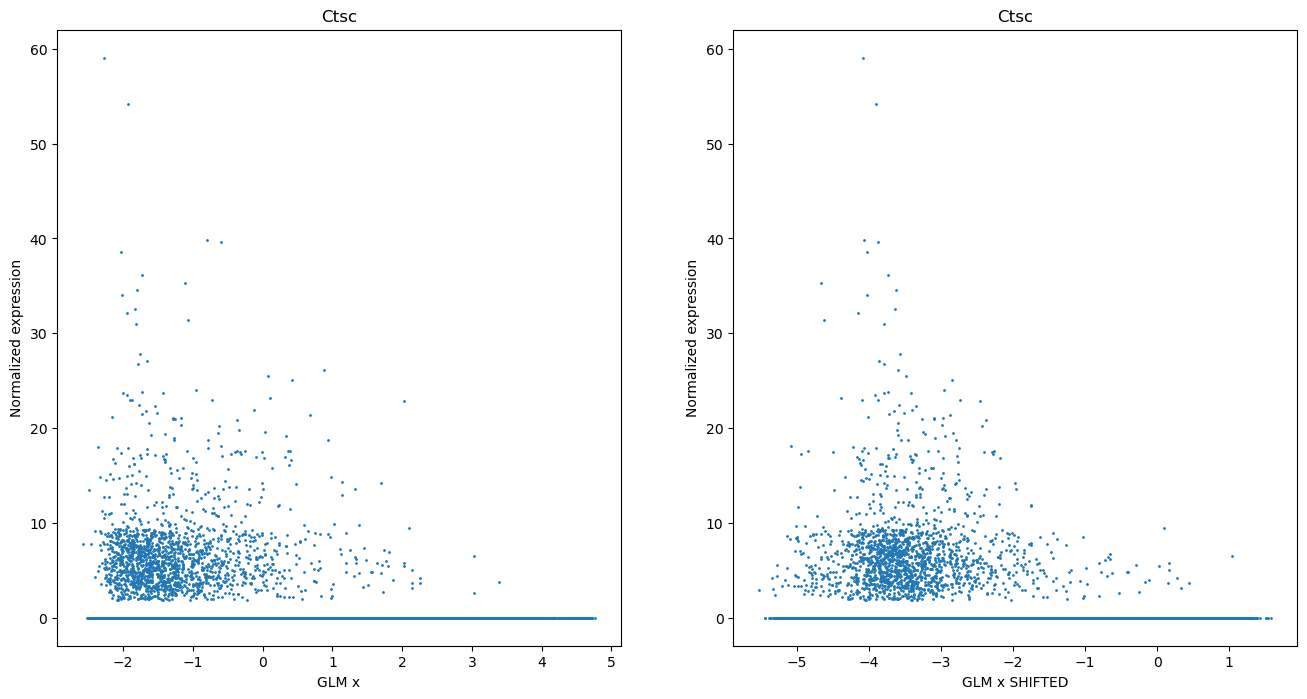

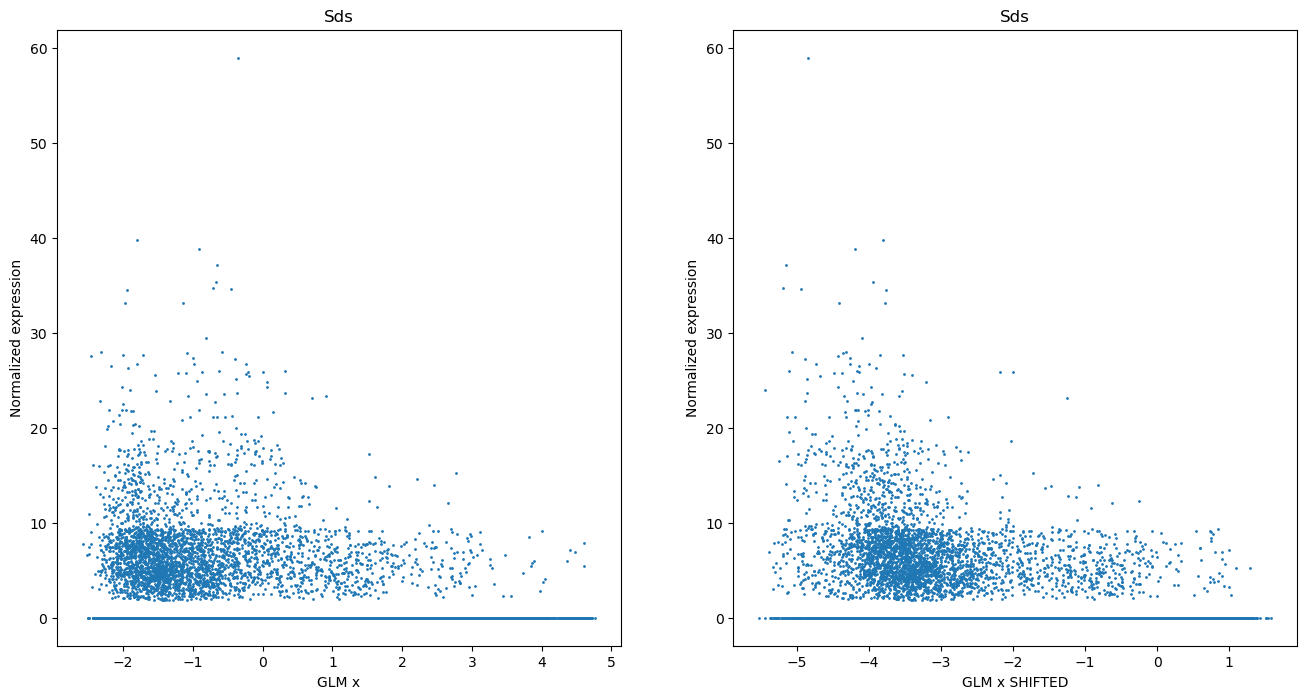

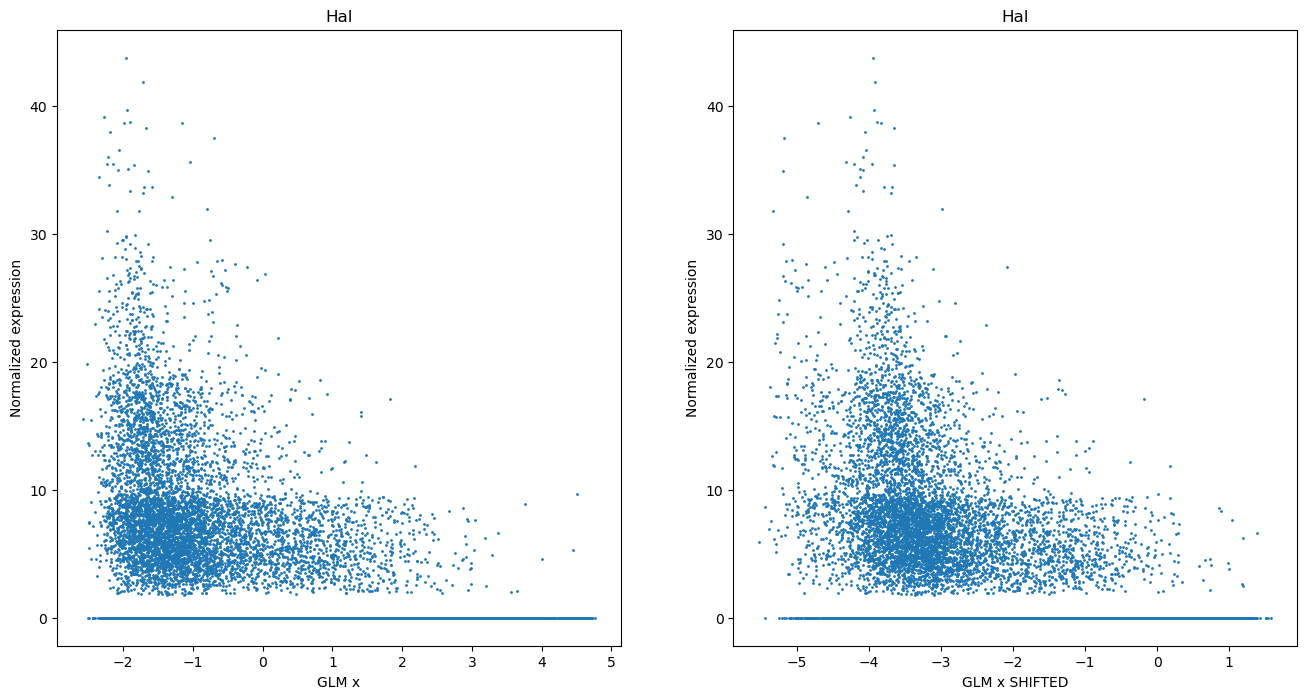

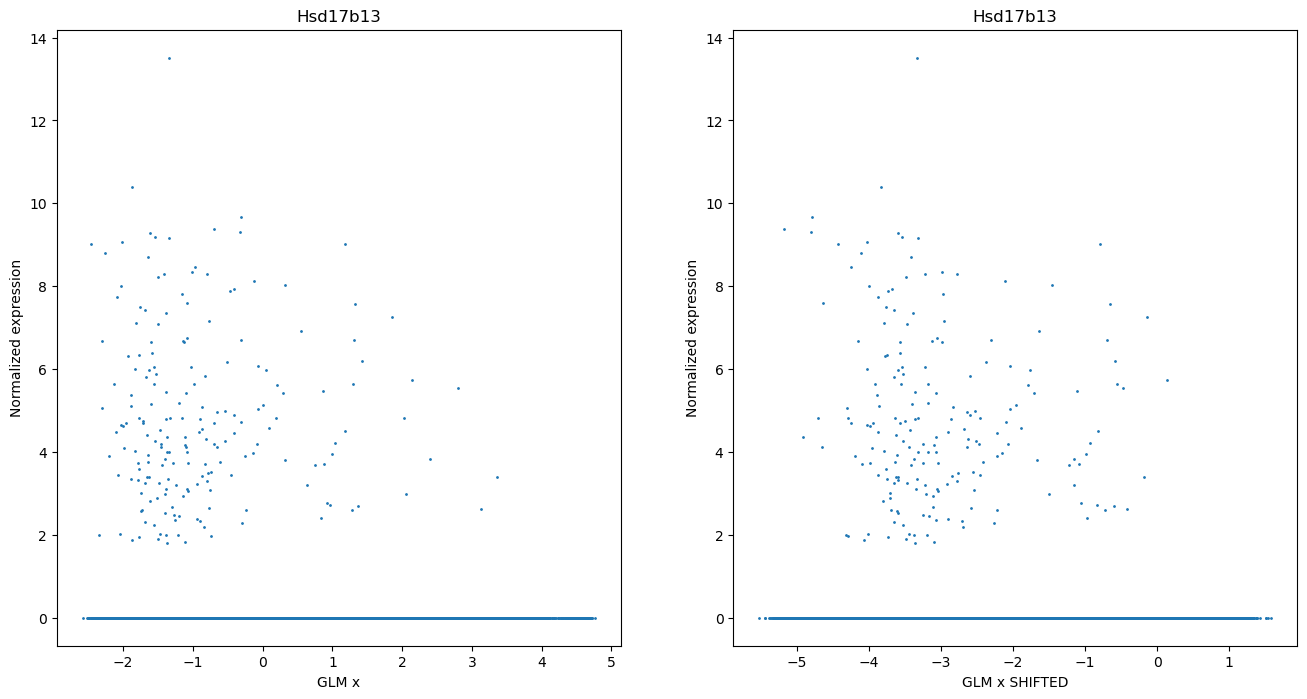

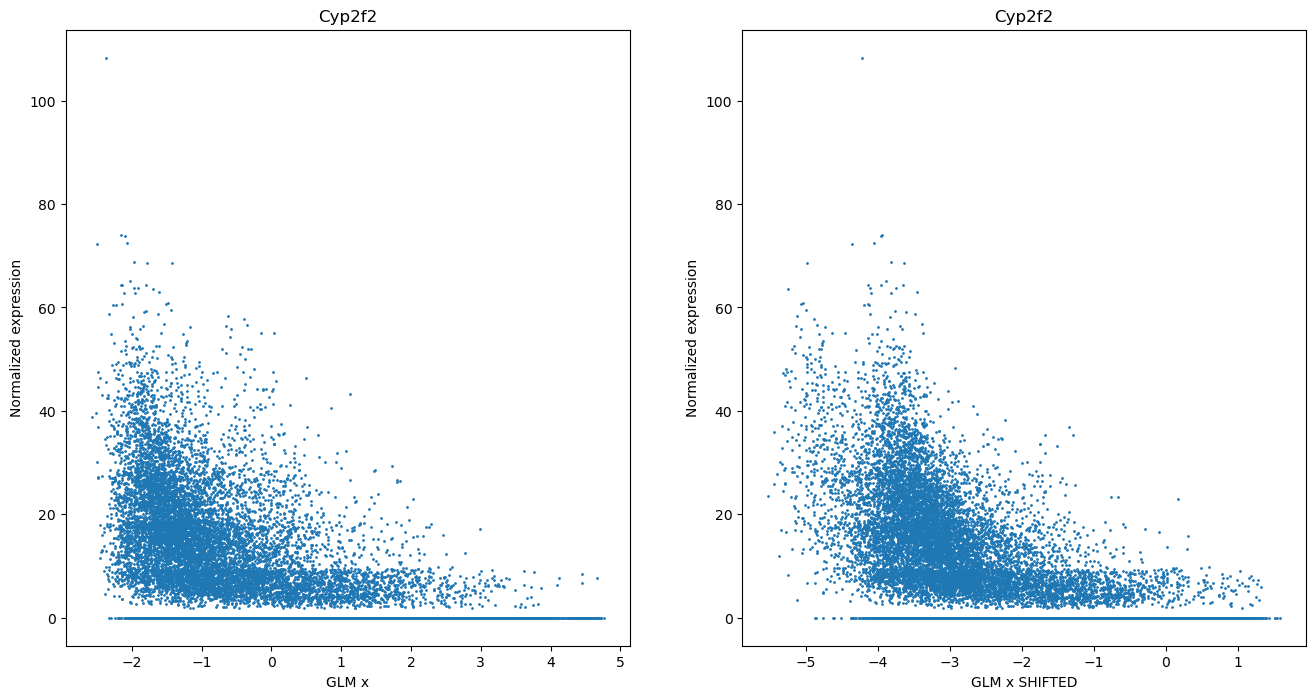

In [58]:
for i,g in enumerate(cfg.genes):
    plt.figure(figsize=(16, 8))
    plt.subplot(121)
    plt.scatter(x_ , data[:, g].layers["f_cg"].squeeze(), s=1)
    plt.title(g)
    plt.xlabel("GLM x")
    plt.ylabel("Normalized expression")

    plt.subplot(122)
    plt.scatter(x_shifted , data[:, g].layers["f_cg"].squeeze(), s=1)
    plt.title(g)
    plt.xlabel("GLM x SHIFTED")
    plt.ylabel("Normalized expression")
    plt.show()